In [41]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
#from sklearn.calibration import calibration_curve
#from sklearn.isotonic import IsotonicRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
#from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [42]:
data = pd.read_csv('merged_data.csv', encoding='latin1')
data.head()

,datapoint_name,dataset_name,n_features,n_instances,categorical_counter,categorical_proportion,numvariable_counter,numvariable_proportion,textual_variables_counter,textual_proportion,date_counter,are_sorted_dates,label_type,label,information
0,animal-disease,data,7,871,7,1.000000,0,0.000000,0,0.0,0,0,2,classification,animal condition classification dataset presen...
1,banking-dataset-classification,new_test,13,8238,10,0.769231,3,0.230769,0,0.0,0,0,2,classification,revenue decline portuguese bank would like kno...
2,banking-dataset-classification,new_train,16,32950,13,0.812500,3,0.187500,0,0.0,0,0,2,classification,revenue decline portuguese bank would like kno...
3,car-acceptability-classification-dataset,car,7,1728,7,1.000000,0,0.000000,0,0.0,0,0,2,classification,car acceptability classification database deri...
4,cervical-cancer-risk-classification,kag_risk_factors_cervical_cancer,30,858,29,0.966667,1,0.033333,0,0.0,0,0,2,classification,cervical cancer risk factors biopsy dataset ob...


In [43]:
def n_trees_error(X, y):
    n_estimators_values = range(1, 201, 10)
    # Lista per memorizzare gli errori medi
    mean_errors = []

    for n_est in n_estimators_values:
        model = RandomForestClassifier(n_estimators=n_est, random_state=42)
        errors = cross_val_score(model, X, y, cv=5, scoring='accuracy')  # Puoi scegliere la metrica di valutazione desiderata
        mean_errors.append(np.mean(errors))
    
    plt.figure(figsize=(8, 4))
    plt.plot(n_estimators_values, mean_errors, label='Accuracy Media', marker='o')
    plt.title('Variazione dell\'Errore al Variare di n_estimators')
    plt.xlabel('n_estimators')
    plt.ylabel('Errore')
    plt.legend()
    plt.grid(True)
    plt.show()

In [44]:
#APPROCCIO MULTI
def ml_classifier_multi(input_data, input_cols, model, categories, result):
    c_data = input_data.copy()
    c_data = c_data[c_data['label'].isin(categories)].reset_index(drop=True) 
    #econding da string a numerico nelle categorie
    for i in range(0,len(c_data)):   
        if (c_data['label'][i] == 'classification'):
            c_data.loc[i, 'label'] = 0
        if (c_data['label'][i] == 'regression'):
            c_data.loc[i, 'label'] = 1
        if (c_data['label'][i] == 'clustering'):
            c_data.loc[i, 'label'] = 2
        if (c_data['label'][i] == 'nlp'):
            c_data.loc[i, 'label'] = 3
        if (c_data['label'][i] == 'time_series'):
            c_data.loc[i, 'label'] = 4
    
    
    X = c_data.loc[:, input_cols]
    y = c_data['label'].astype(int)
    
    #codifica la variabile testuale utilizzando TfidfVectorizer
    tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Modifica il numero di features secondo necessità
    X_text_tfidf = tfidf_vectorizer.fit_transform(X['information']).toarray()
    
    #concatena la rappresentazione numerica e quella testuale
    feature_names_numeric = input_cols[0:-1]
    feature_names_text = [f'text_{i}' for i in range(X_text_tfidf.shape[1])]
    X_combined = pd.concat([X[feature_names_numeric], pd.DataFrame(X_text_tfidf, columns=feature_names_text)], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, shuffle=True, random_state=42)
   
    #esporta i dataset train e test
    #X_train.to_csv('XY_Data'+ '/' + category +'/' + 'X_train.csv', index=False)
    #X_test.to_csv('XY_Data'+ '/' + category +'/' + 'X_test.csv', index=False)
    #y_train.to_csv('XY_Data'+ '/' + category +'/' + 'y_train.csv', index=False)
    #y_test.to_csv('XY_Data'+ '/' + category +'/' + 'y_test.csv', index=False)
    
    #errore random forest in funzione di n estimator
    n_trees_error(X_train, y_train)
    print('TEST Accuracy (RANDOM STATE = 42)')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    print(f'Accuracy: {accuracy}')
    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", conf_matrix)
    
    result['expected'] = y_test
    result['predicted'] = y_pred
    
    
    #CROSS VALIDATION
    # Specifica il numero di fold per la cross-validation
    n_folds = 10  # Puoi regolare questo valore in base alle tue esigenze

    # Inizializza l'oggetto StratifiedKFold
    stratk_fold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    y_pred = cross_val_predict(model, X_combined, y, cv=stratk_fold)
    # Stampa il classification report
    print()
    print('TEST CROSS VALIDATION folds = 10')
    print(classification_report(y, y_pred))
    
    # Ottieni l'importanza delle features
    #importances = model.feature_importances_
    #indices = np.argsort(importances)[::-1]

    # Stampa l'importanza delle features in ordine
    #print("Importanza delle features:")
    #for f in range(X.shape[1]):
        #print(f"{X.columns[indices[f]]}: {importances[indices[f]]}")


Index(['categorical_counter', 'categorical_proportion', 'numvariable_counter',
       'numvariable_proportion', 'textual_variables_counter',
       'textual_proportion', 'date_counter', 'are_sorted_dates', 'label_type',
       'information'],
      dtype='object')


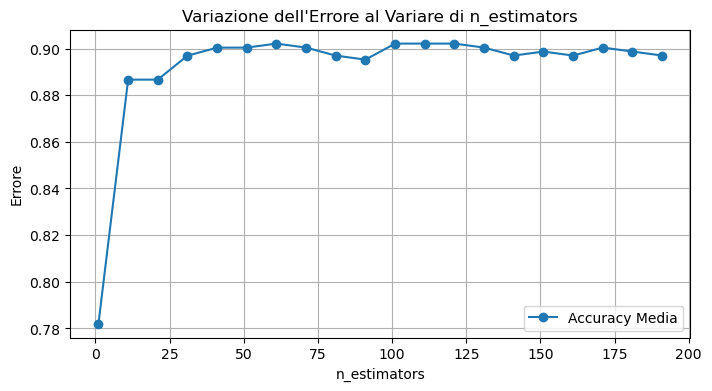

TEST Accuracy (RANDOM STATE = 42)
Accuracy: 0.900398406374502
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.75      0.81        20
           1       0.79      0.88      0.83        34
           2       0.88      0.75      0.81        40
           3       0.91      0.96      0.94        54
           4       0.94      0.96      0.95       103

    accuracy                           0.90       251
   macro avg       0.88      0.86      0.87       251
weighted avg       0.90      0.90      0.90       251

Confusion Matrix:
 [[15  4  1  0  0]
 [ 1 30  1  0  2]
 [ 1  2 30  3  4]
 [ 0  0  2 52  0]
 [ 0  2  0  2 99]]

TEST CROSS VALIDATION folds = 10
              precision    recall  f1-score   support

           0       0.84      0.80      0.82        71
           1       0.89      0.75      0.81       108
           2       0.82      0.78      0.80       144
           3       0.88      0.97      0.92       166
          

In [45]:
#risultato per vedere quali righe sbagliate e quali giuste nel dettaglio
result = pd.DataFrame(columns=['expected', 'predicted'])
#escludo la penultima colonna che è label
cols = data.columns[4:-2].append(pd.Index([data.columns[len(data.columns)-1]]))
#cols = merged_data.columns[4:-2]
print(cols)

model = RandomForestClassifier(n_estimators=50, random_state=42)
data['information'].fillna('', inplace=True)
ml_classifier_multi(data, cols, model, ['classification', 'regression', 'nlp', 'clustering', 'time_series'], result)

#0 - classification
#1 - regression
#2 - clustering
#3 - nlp
#4 - time series

In [ ]:
#Per vedere quali righe ha azzeccato e quali sbagliato nello specifico
result['expected']=result['expected'].replace({0: 'classification', 1: 'regression', 2: 'clustering', 
                                               3: 'nlp', 4: 'time_series'})
result['predicted']=result['predicted'].replace({0: 'classification', 1: 'regression', 2: 'clustering', 
                                               3: 'nlp', 4: 'time_series'})
result.head()